### Credit Default Risk Prediction: Unveiling Hidden Patterns in Loan Defaults with Machine Learning

Unique features of my code:
- Automated feature selection
- Automated model selection
- Automated hyperparameter tuning
- Proper plots and observations

### Import Necessary Libraries and define constants

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, auc, classification_report, roc_curve, \
    						precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from IPython.display import Markdown

from common_functions import load_data_from_url, save_plot, \
    evaluate_model, get_model_scores, hyperparam_tuning, RANDOM_STATE

np.random.seed(RANDOM_STATE)

TEST_SIZE = 0.2
SAVE_IMAGES = False  # True to save images automatically for plots

Defaulting to user installation because normal site-packages is not writeable


### Load the Dataset

In [2]:
dataset_url = 'http://cox.csueastbay.edu/~esuess/classes/Statistics_652/Presentations/03-Regression/credit.csv'
df = load_data_from_url(dataset_url, 'Credit_Default_data.csv')
df.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


### Initial Exploration and Exploratory Data Analysis

#### Basic info

In [3]:
print('Number of rows:', df.shape[0])
print('Missing values count:', df.isnull().values.sum())
print(f'\nData Types:\n{df.dtypes}')

Number of rows: 1000
Missing values count: 0

Data Types:
checking_balance        object
months_loan_duration     int64
credit_history          object
purpose                 object
amount                   int64
savings_balance         object
employment_duration     object
percent_of_income        int64
years_at_residence       int64
age                      int64
other_credit            object
housing                 object
existing_loans_count     int64
job                     object
dependents               int64
phone                   object
default                 object
dtype: object


#### Data Visualization

In [4]:
# Function to create plots

def to_title_case(label):
	return label.replace('_', ' ').title()

def create_plot(df, plot_type, column, title=None, hue=None, xlabel=None, ylabel=None):
	plt.figure()  # Create a new figure for each plot

	if plot_type == 'countplot':  # Generate the appropriate plot
		sns.countplot(x=column, hue=hue, data=df)
	elif plot_type == 'histplot':
		sns.histplot(df[column])
	elif plot_type == 'boxplot':
		sns.boxplot(x=hue, y=column, data=df)

	# Set the title and labels, and save the plot
	if hue and hue.lower() == 'default':
		hue = hue + '_status'
	if xlabel is None:
		xlabel = to_title_case(column)
	plt.xlabel(xlabel)
	if hue:
		if ylabel is None:
			ylabel = to_title_case(hue)
		plt.ylabel(ylabel)

	if not title:
		# Generate title based on input columns
		title = xlabel
		if hue:
			title += f' vs {ylabel}'
	plt.title(title)
	title_without_spaces = title.replace(' ', '_')
	save_plot(f'{title_without_spaces}.png', plt, SAVE_IMAGES)
	plt.show()

print('Functions defined')

Functions defined


#### Part-1

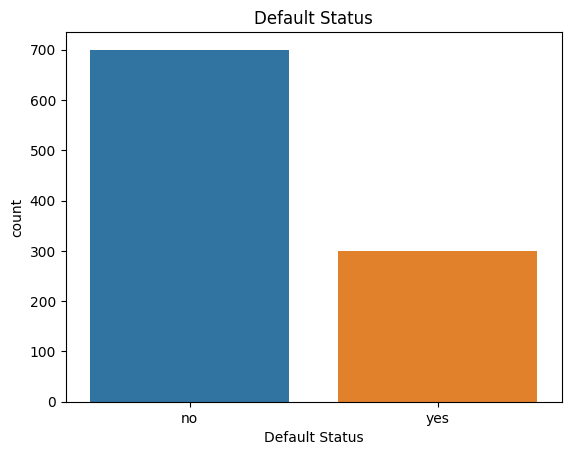

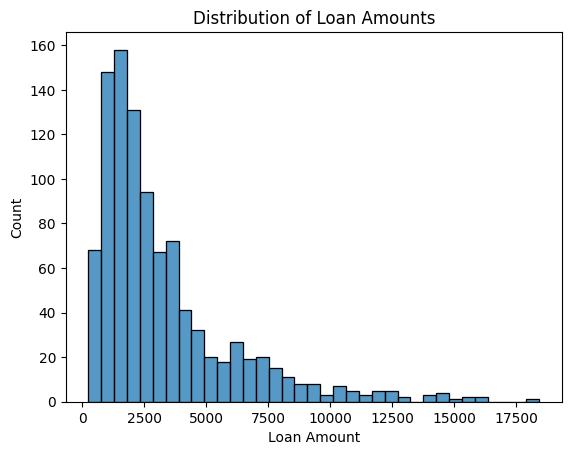

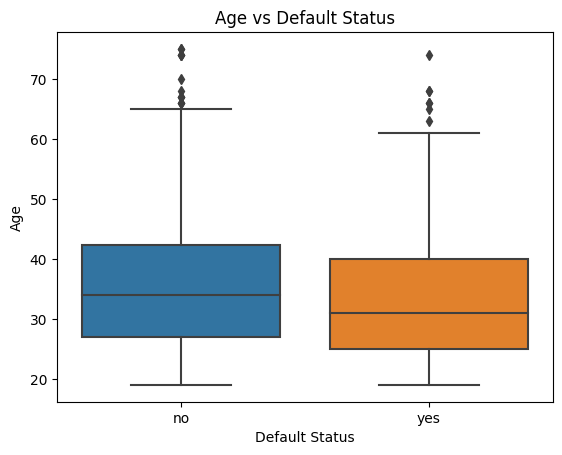

In [5]:
target = 'default'

# Visualizations of 'default' for data exploration
create_plot(df, 'countplot', target, xlabel='Default Status', ylabel='Count')

# Visualizing distribution of loan amounts
create_plot(df, 'histplot', 'amount', 'Distribution of Loan Amounts', xlabel='Loan Amount')

# Relationship between age and loan default
create_plot(df, 'boxplot', 'age', 'Age vs Default Status', hue=target,
			xlabel='Default Status', ylabel='Age')

**Observations:**

- **Default Status Bar Chart:** The majority have not defaulted on their loans, with a much higher count in the 'no' category compared to the 'yes'.

- **Distribution of Loan Amounts Histogram:** Loan amounts are right-skewed, with most loans being of smaller amounts and a rapid decrease in frequency as the amount increases.

- **Age vs Default Status Box Plot:** Both default groups have a similar age distribution, but those who have not defaulted show slightly less age variability. We can observe that the younger the age, the higher the default rate.

#### Part-2

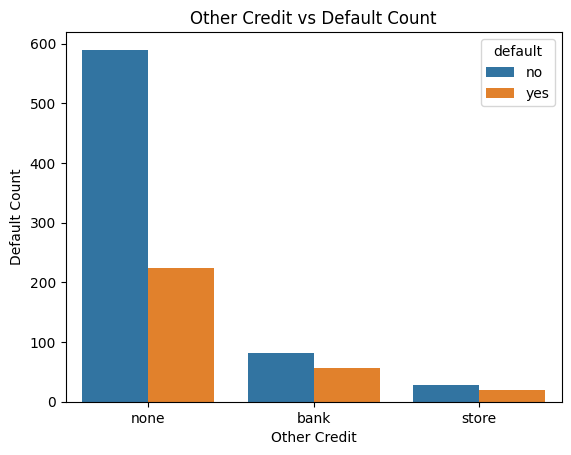

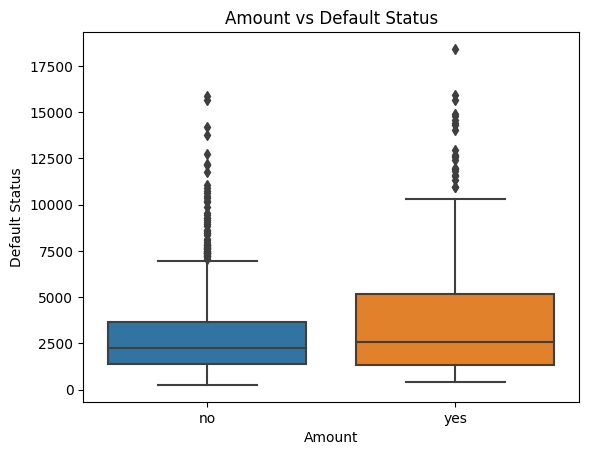

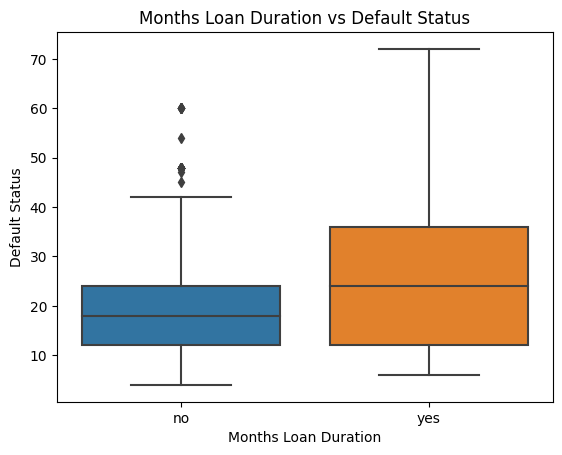

In [6]:
# More relationships

# Creating a countplot to analyze the impact of other credits on default status
create_plot(df, 'countplot', 'other_credit', hue=target, ylabel='Default Count')

# Creating a boxplot to compare loan amounts with default status
create_plot(df, 'boxplot', 'amount', hue=target)

# Creating a boxplot to analyze the relationship between loan duration and default status
create_plot(df, 'boxplot', 'months_loan_duration', hue=target)

**Observations:**

- **Other Credit vs Default Status Bar Chart**
   - Most individuals with no other credit have not defaulted, while those with credit from banks or stores have a higher proportion of defaults.
   - Individuals with no other credit represent the largest group, followed by those with bank credit, and the fewest have credit from stores.

- **Loan Amount vs Default Status Box Plot**
   - The median loan amount for those who defaulted appears higher than for those who did not.
   - We can observe that the higher the loan amount, the more likely the individual is to default.

- **Loan Duration vs Default Status Box Plot**
   - Defaulters tend to have longer loan durations, as indicated by a higher median and wider interquartile range.

#### Part-3

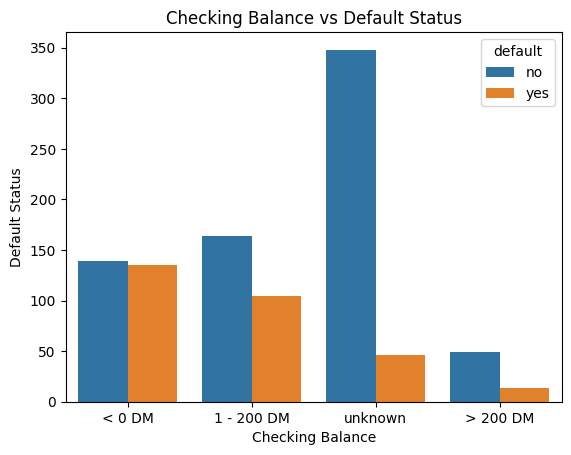

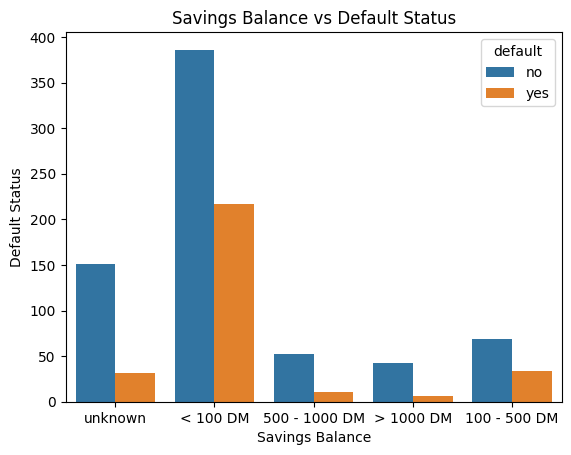

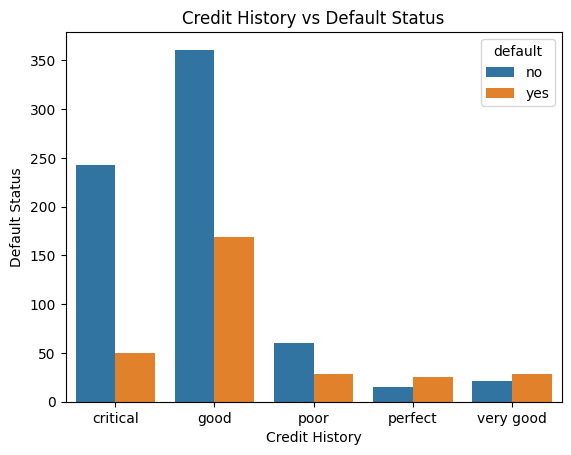

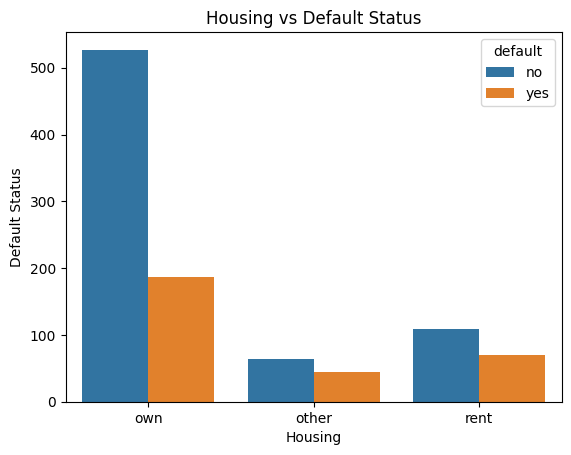

In [7]:
# Creating a countplot to compare checking balance with default status
create_plot(df, 'countplot', 'checking_balance', hue=target)

# Creating a countplot to compare savings balance with default status
create_plot(df, 'countplot', 'savings_balance', hue=target)

# Creating a countplot to explore the relationship between credit history and default status
create_plot(df, 'countplot', 'credit_history', hue=target)

# Creating a countplot to analyze the impact of housing status on loan default
create_plot(df, 'countplot', 'housing', hue=target)

**Observations:**

- **Checking Balance vs Default Status**
   - A higher proportion of individuals with unknown checking balance have defaulted compared to those with known checking balances.
   - Very few individuals with a checking balance of over 200 DM have defaulted, suggesting a possible correlation between higher checking balances and lower default rates.

- **Savings Balance vs Default Status**
   - Individuals with unknown savings balance or a balance less than 100 DM have a higher rate of default.
   - Default rates decrease significantly for individuals with higher savings balances, with the least defaults seen in the 500 - 1000 DM category.

- **Credit History vs Default Status**
   - People with a 'good' credit history have the lowest default rates, while those with a 'critical' credit history have the highest.
   - The number of defaults is significantly lower for individuals with 'perfect' or 'very good' credit histories.

- **Housing vs Default Status**
   - Individuals who own their homes have a significantly lower default rate compared to those who rent or have other housing arrangements.
   - The 'rent' category shows a higher number of defaults, possibly indicating financial instability or less financial reserves compared to homeowners.

### Data Manipulation and Wrangling

#### Mapping Categorical Variables to Numeric values

In [8]:
# Categorize the ages into groups using common values of 0, 25, ...
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 50, 75, 100], 
                        labels=['Young', 'Adult', 'Senior', 'Elderly'])

# df['loan_to_savings_ratio'] = df['amount'] / (df['savings_balance'] + 1)

# under purpose, replace car0 with car
df['purpose'] = df['purpose'].replace('car0', 'car')

# Convert some columns to numeric, as a value is superior to another

column_mappings = {
    'credit_history': {'critical': 0, 'poor': 1, 'good': 2, 'very good': 3, 'perfect': 4},
    'job': {'unemployed': 0, 'unskilled': 1, 'skilled': 2, 'management': 3},
    'age_group': {'Young': 0, 'Adult': 1, 'Senior': 2, 'Elderly': 3},
    'other_credit': {'none': 0, 'store': 1, 'bank': 2},  # Store credit is better than bank credit
    'checking_balance': {'unknown': 0, '< 0 DM': 1, '1 - 200 DM': 2, '> 200 DM': 3},
    'savings_balance': {'unknown': 0, '< 100 DM': 1, '100 - 500 DM': 2, '500 - 1000 DM': 3, '> 1000 DM': 4},
    'employment_duration': {'unemployed': 0, '< 1 year': 1, '1 - 4 years': 2, '4 - 7 years': 3, '> 7 years': 4},
    # 'other' is lower than 'rent' because it can include living in a hostel or hotel
    #    or the house of friends, being homeless, etc
    'housing': {'other': 0, 'rent': 1, 'own': 2},
    'phone': {'no': False, 'yes': True},
    # # # one purpose is not superior others, but it is better to convert them to numbers for better predictions
    # # 'purpose': {'furniture/appliances': 0, 'car': 1, 'business': 2, 'education': 3, 'renovations': 4},
    'default': {'no': False, 'yes': True},
}

# if checking_balance or savings_balance is unknown, set checking_balance_unknown or savings_balance_unknown to True
df['checking_balance_unknown'] = df['checking_balance'] == 'unknown'
df['savings_balance_unknown'] = df['savings_balance'] == 'unknown'

# Applying the mappings to the DataFrame
for category, mapping in column_mappings.items():
    if any(x in df[category].values for x in mapping.keys()):
        df[category] = df[category].map(mapping)

df.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default,age_group,checking_balance_unknown,savings_balance_unknown
0,1,6,0,furniture/appliances,1169,0,4,4,4,67,0,2,2,2,1,True,False,2,False,True
1,2,48,2,furniture/appliances,5951,1,2,2,2,22,0,2,1,2,1,False,True,0,False,False
2,0,12,0,education,2096,1,3,2,3,49,0,2,1,1,2,False,False,1,True,False
3,1,42,2,furniture/appliances,7882,1,3,2,4,45,0,0,1,2,2,False,False,1,False,False
4,1,24,1,car,4870,1,2,3,4,53,0,0,2,2,2,False,True,2,False,False


#### Inverted mappings to get original labels

In [9]:
inverted_mappings = {category: {v: k for k, v in mapping.items()} for category, mapping in column_mappings.items()}

def set_categorical_ticks(ax, feature, inverted_mappings, x_axis=True, rotation=None):
    # Check if the feature is in the inverted_mappings dictionary
    if feature not in inverted_mappings:
        return
    
    # Get the current ticks from the axis
    ticks = ax.get_xticks() if x_axis else ax.get_yticks()
    
    # Create the labels using the inverted_mappings
    labels = [inverted_mappings[feature].get(tick, '') for tick in ticks]
    
    # Set the tick labels on the axis
    if x_axis:
        ax.set_xticklabels(labels, rotation=rotation if rotation is not None else 0)
    else:
        ax.set_yticklabels(labels, rotation=rotation if rotation is not None else 0)

print('Function defined')

Function defined


### Data Pre-processing

In [10]:
# Convert categorical variables to dummy variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.head()

,checking_balance,months_loan_duration,credit_history,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,...,default,checking_balance_unknown,savings_balance_unknown,purpose_car,purpose_education,purpose_furniture/appliances,purpose_renovations,age_group_1,age_group_2,age_group_3
0,1,6,0,1169,0,4,4,4,67,0,...,False,False,True,0,0,1,0,0,1,0
1,2,48,2,5951,1,2,2,2,22,0,...,True,False,False,0,0,1,0,0,0,0
2,0,12,0,2096,1,3,2,3,49,0,...,False,True,False,0,1,0,0,1,0,0
3,1,42,2,7882,1,3,2,4,45,0,...,False,False,False,0,0,1,0,1,0,0
4,1,24,1,4870,1,2,3,4,53,0,...,True,False,False,1,0,0,0,0,1,0


### Feature Engineering

#### Feature Selection using correlation matrix

In [11]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Compute the absolute values of correlations with the target variable
# To show highly negatively correlated variables at first as well
absolute_correlations = correlation_matrix[target].abs().sort_values(ascending=False)
# Remove the target variable itself
absolute_correlations = absolute_correlations.drop(target)

# Display correlations with the target variable
absolute_correlations[:3]

checking_balance_unknown    0.322436
credit_history              0.228785
months_loan_duration        0.214927
Name: default, dtype: float64

In [12]:
# Consider all with correlation value > threshold
correlation_threshold = 0.1
selected_features = absolute_correlations[absolute_correlations > correlation_threshold]
selected_features = list(selected_features.index.values)
selected_features[:5]  # view first 5

['checking_balance_unknown',
 'credit_history',
 'months_loan_duration',
 'checking_balance',
 'amount']

#### Visualization of the selected features

#### Pair plot

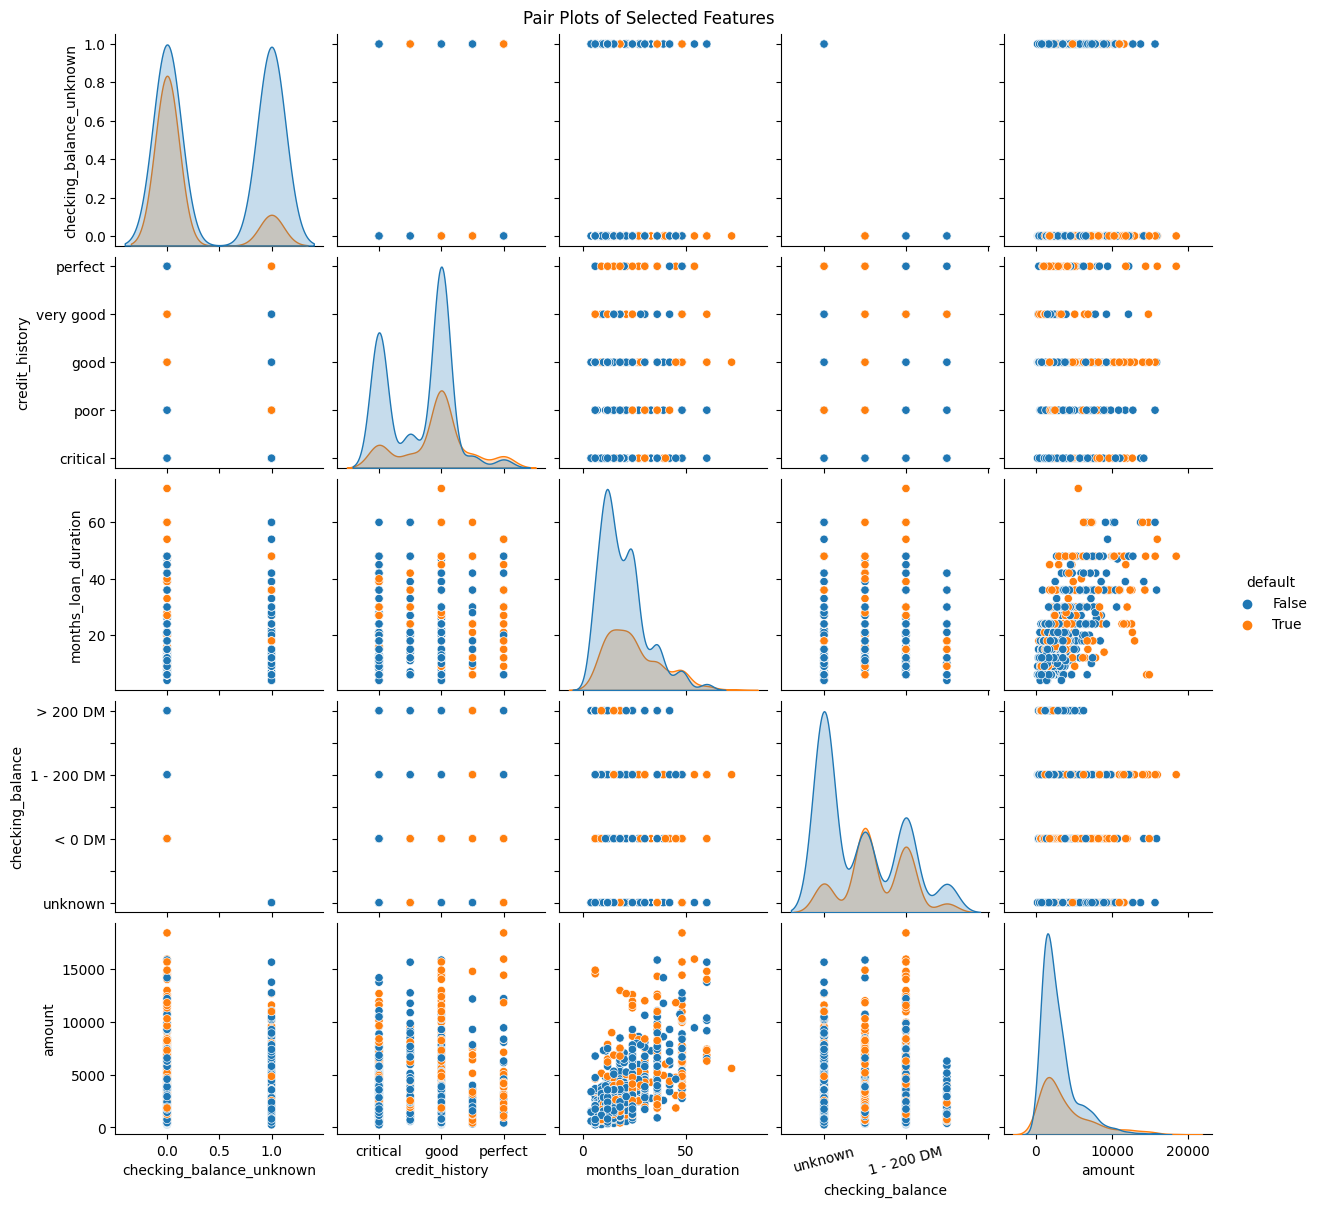

In [13]:
warnings.filterwarnings('ignore', category=UserWarning)

# Add Pair Plots using selected_features
# Used only first 5 to avoid cluttering in small space. First 5 are the most correlated
pairplot = sns.pairplot(df, vars=selected_features[:5], hue=target)
plt.subplots_adjust(top=0.96, left=0.1, bottom=0.08)
plt.suptitle('Pair Plots of Selected Features')
for i, row_axes in enumerate(pairplot.axes):
    for j, ax in enumerate(row_axes):
        # For the x-axis on the bottom row, set the custom labels
        if i == len(pairplot.axes) - 1:  # Bottom row
            rotation_angle = 15 if selected_features[j].endswith('_balance') else None  # Rotation improves their view
            set_categorical_ticks(ax, selected_features[j], inverted_mappings, x_axis=True, rotation=rotation_angle)

        # For the y-axis on the first column or the diagonal, set the custom labels
        if j == 0 or i == j:  # First column or diagonal
            set_categorical_ticks(ax, selected_features[i], inverted_mappings, x_axis=False)
save_plot('Pair_Plots_of_Selected_Features', plt, SAVE_IMAGES)
plt.show()

**Observations:**
- **Credit History**: There are distinct groups particularly for 'critical' and 'good' credit history categories, indicating a polarization in customers' creditworthiness.
- **Loan Duration and Amount**: A cluster of shorter loan durations and smaller loan amounts can be observed, with fewer instances of higher amounts or longer durations.
- **Defaults**: Defaults are present across various credit histories, with a higher visibility among certain categories, although no strong pattern is discernible.
- **Checking Balance**: A significant number of entries with 'unknown' checking balance are evident, alongside clusters at lower balance ranges.
- **Scatter Plots**: There is no clear linear relationship between loan attributes and defaults, implying that other variables or complex interactions might play a role in default prediction.
- **Density Plots**: The density plots for loan amount and duration lean towards smaller and shorter loans, which is typical in consumer lending. 

#### Correlation Matrix

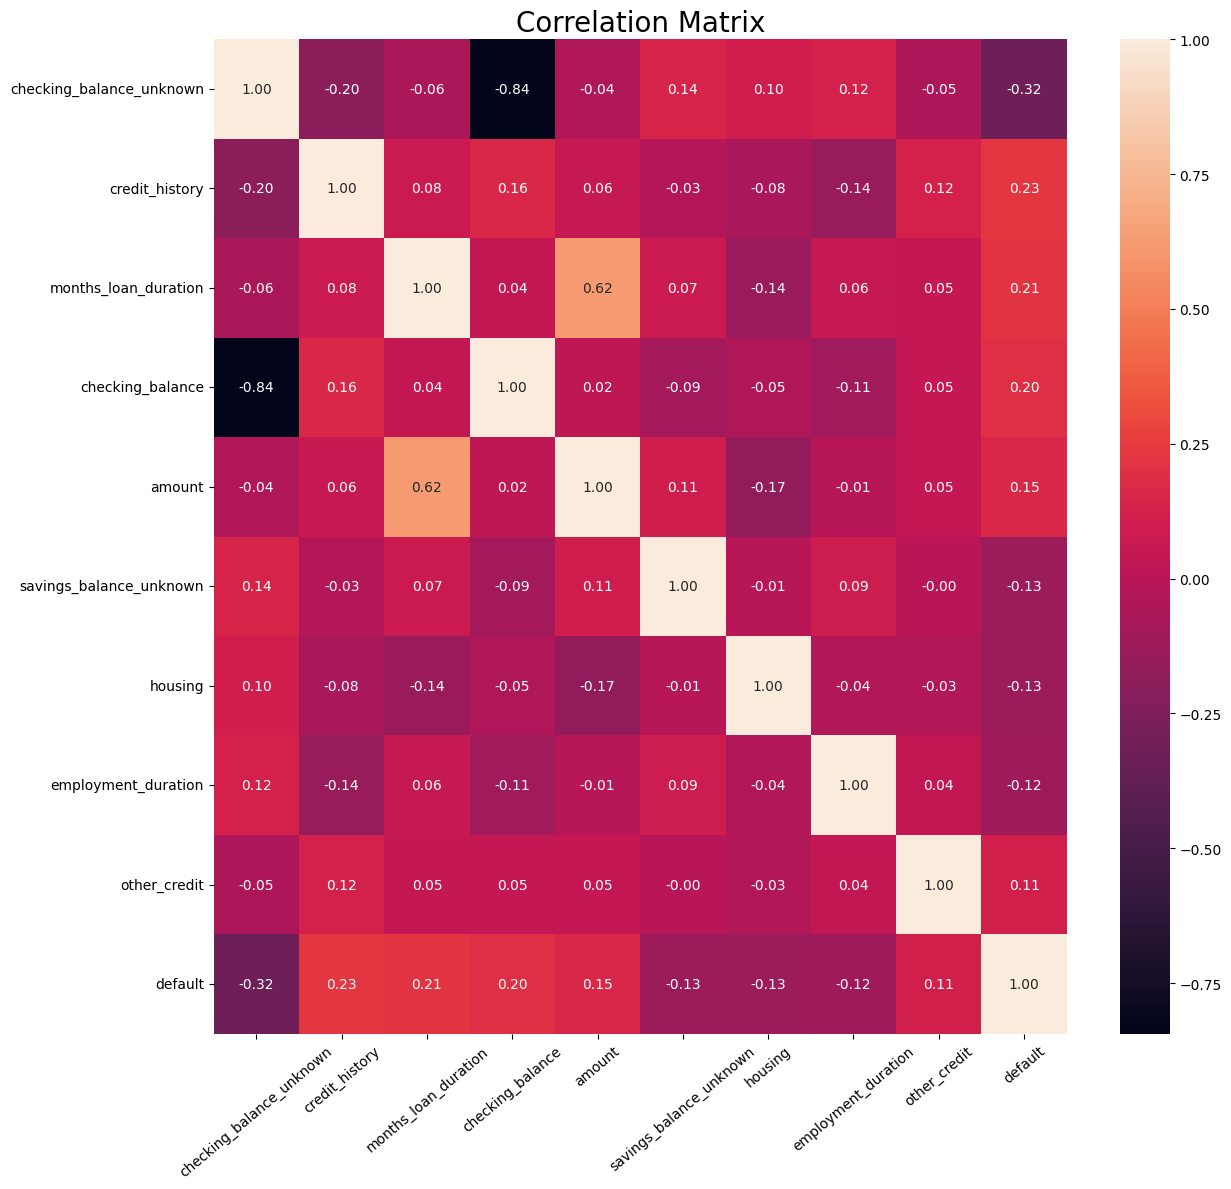

In [14]:
# Visualize correlation matrix in Seaborn using a heatmap
correlation_matrix = df[selected_features + [target]].corr()

plt.figure(figsize=(13, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix', fontsize=20)
plt.subplots_adjust(top=0.96, bottom=0.1, left=0.14)
plt.xticks(rotation=40)
plt.tight_layout()
save_plot('Correlation_Matrix.png', plt, SAVE_IMAGES)
plt.show()

**Observations:**
- Correlation between 'unknown' checking balance and actual checking balance, as we mapped 'unknown' to 0. It is to be ignored.
- Mild positive correlations exist between credit history, loan duration, and amount with defaults, suggesting these factors have some influence on default risk.
- Housing, employment duration, and other credit show little to no correlation with defaults, hinting at a more complex interplay with default risk.
- Generally, the correlations are weak, underscoring the multifaceted nature of credit risk assessment.

### Splitting the data into training and test sets

In [15]:
selected_features

['checking_balance_unknown',
 'credit_history',
 'months_loan_duration',
 'checking_balance',
 'amount',
 'savings_balance_unknown',
 'housing',
 'employment_duration',
 'other_credit']

In [16]:
# Consider selected_predictors for training
X = df[selected_features]  # Multi-variate training data using all selected features
y = df[target]

# Split the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_train.shape

(800, 9)

### Pre-processing the training and testing data

In [17]:
# Convert to contiguous array for improved performance and compatibility with KNN
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# Convert boolean target variable to integer
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Fit and transform the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape

(800, 9)

### Choosing a model

##### Chosen models to try and reasons for choosing them:

- **Logistic Regression**:
  - **Simplicity and Speed**: Efficient for small datasets and offers fast training.
  - **Probabilistic Interpretation**: Gives probabilities for outcomes, aiding in decision-making.
  - **Binary Classification**: Highly effective for binary outcome predictions.
  - **Linear Relationships**: Best for scenarios where predictors have a linear relationship with the target.
  - **Interpretability**: Model coefficients provide understandable insights into feature importance.

- **Random Forest**:
  - **Robustness**: Reduces overfitting by averaging multiple decision trees.
  - **Feature Handling**: Effectively manages both categorical and numerical data.
  - **Non-Linearity**: Excels in capturing complex, non-linear relationships in data.
  - **Feature Importance Analysis**: Offers valuable insights into key predictive features.
  - **Imbalanced Data Handling**: Performs reliably even with uneven data distributions.

- **Gradient Boosting**:
  - **Sequential Learning**: Improves accuracy by correcting previous trees' errors.
  - **High Performance**: Often yields superior predictive accuracy.
  - **Flexibility**: Can optimize on different loss functions, tailored to various problems.
  - **Handling of Complex Data**: Effective in complex, non-linear data scenarios.
  - **Regularization**: Integrated mechanisms to prevent overfitting.

<!-- - **XGBoost**:
  - **Speed and Performance**: Optimized for speed and efficiency.
  - **Regularization**: Reduces overfitting through built-in regularization.
  - **Scalability**: Scales well to large datasets and high-dimensional spaces.
  - **Customization**: Supports custom optimization objectives and evaluation criteria.
  - **Cross-Validation**: Built-in cross-validation method to optimize parameters.

- **CatBoost**:
  - **Handling Categorical Data**: Excellently processes categorical features without extensive pre-processing.
  - **Robust to Overfitting**: Particularly effective in preventing overfitting in complex models.
  - **Performance**: Competes closely with other advanced boosting models.
  - **User-Friendly**: Easy to use with minimal parameter tuning required.
  - **Speed**: Offers fast training and prediction speeds, beneficial for large datasets. -->

- **Support Vector Machine**:
  - **Effective in High Dimension**: Performs well in high-dimensional spaces.
  - **Versatility**: Kernel trick allows for complex decision boundaries.
  - **Margin Maximization**: Focuses on maximizing the margin, improving generalization.
  - **Outlier Handling**: Less sensitive to outliers due to margin approach.
  - **Binary Classification**: Particularly effective for binary classification tasks.

##### Trying out the above models to see which one performs the best

###### Evaluate the models

**Note:** The difference between the training and test scores (`Train Score - Test Score`) is considered here as a measure for overfitting. However, there is no universal formula to calculate that.

In [18]:
# Find accuracy by trying different models

warnings.filterwarnings('ignore', category=UserWarning)

# Models to try (includes models covered in the lectures)
models_to_try = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE),
    'CatBoost': CatBoostClassifier(silent=True, random_state=RANDOM_STATE),  # 'silent=True' to avoid warnings
    'Support Vector Machine': SVC(probability=True, random_state=RANDOM_STATE),
    # 'LightGBM': LGBMClassifier(verbose=-1, random_state=RANDOM_STATE),  # 'verbose=-1' to avoid warnings
    # 'K-Nearest Neighbors': KNeighborsClassifier(),
}

scores_df = get_model_scores(models_to_try, X_train, y_train, X_test, y_test, X, y)
scores_df

,Model,Test Accuracy,Train Accuracy,Overfitting value,CV Accuracy,Confusion Matrix Accuracy,F1-Score,ROC AUC Score,Average Precision Score
0,CatBoost,0.800,0.90750,0.10750,0.757,0.800,0.591837,0.832552,0.694679
1,Gradient Boosting,0.795,0.87000,0.07500,0.753,0.795,0.577320,0.848419,0.692639
2,Support Vector Machine,0.795,0.81000,0.01500,0.708,0.795,0.559140,0.752134,0.648138
3,Logistic Regression,0.765,0.75125,0.00000,0.739,0.765,0.505263,0.809472,0.609571
4,XGBoost,0.765,0.99375,0.22875,0.735,0.765,0.534653,0.791081,0.611362
5,Random Forest,0.755,1.00000,0.24500,0.736,0.755,0.505051,0.774612,0.639060


**Observations:**
- **CatBoost**: Exhibits the highest test accuracy and a moderate level of overfitting. It shows robust performance with the second-highest ROC AUC Score.
- **Gradient Boosting**: Offers a strong balance between test accuracy and overfitting, coupled with the highest ROC AUC Score, suggesting excellent model performance.
- **Support Vector Machine (SVM)**: Demonstrates high test accuracy with very little overfitting, indicating strong generalization capabilities, though the ROC AUC Score is lower than others.
- **Logistic Regression**: Shows the least overfitting with no discrepancy between training and test accuracies, suggesting a very stable model, but with lower test accuracy and F1-Score.
- **XGBoost**: Presents significant overfitting with the highest discrepancy between training and test accuracies, which may affect its generalization to unseen data despite a reasonable ROC AUC Score.
- **Random Forest**: Also displays substantial overfitting, with perfect training accuracy but lower test performance metrics, indicating potential challenges in generalizing to new data.

##### Selecting the best model using the above scores, with my new algorithm

In [19]:
scaler = MinMaxScaler()

best_model_df = scores_df.copy()
best_model_df.drop(columns=['Train Accuracy', 'Overfitting value'], inplace=True)

# Select scores and normalize them with MinMaxScaler
scores_to_consider = ['Test Accuracy', 'CV Accuracy', 'Confusion Matrix Accuracy', 'F1-Score', 'ROC AUC Score']
best_model_df[scores_to_consider] = scaler.fit_transform(best_model_df[scores_to_consider])

# Use the sum of normalized scores as the selection score
best_model_df['Selection Score'] = best_model_df[scores_to_consider].sum(axis=1)
# normalize the selection score as well
best_model_df['Selection Score_0-1'] = scaler.fit_transform(best_model_df[['Selection Score']])

# Sort by the selection score
best_model_df.sort_values(by='Selection Score', ascending=False, inplace=True)

# Rename score columns to add '_0-1' suffix
best_model_df.columns = [f'{col}_0-1' if col in scores_to_consider else col for col in best_model_df.columns]

best_model_df

,Model,Test Accuracy_0-1,CV Accuracy_0-1,Confusion Matrix Accuracy_0-1,F1-Score_0-1,ROC AUC Score_0-1,Average Precision Score,Selection Score,Selection Score_0-1
0,CatBoost,1.000000,1.000000,1.000000,1.000000,0.835206,0.694679,4.835206,1.000000
1,Gradient Boosting,0.888889,0.918367,0.888889,0.832725,1.000000,0.692639,4.528870,0.923992
2,Support Vector Machine,0.888889,0.000000,0.888889,0.623247,0.000000,0.648138,2.401025,0.396033
4,XGBoost,0.222222,0.551020,0.222222,0.341102,0.404494,0.611362,1.741061,0.232283
3,Logistic Regression,0.222222,0.632653,0.222222,0.002450,0.595506,0.609571,1.675053,0.215905
5,Random Forest,0.000000,0.571429,0.000000,0.000000,0.233458,0.639060,0.804887,0.000000


In [20]:
# Return the model with the highest selection score
selected_model_name = best_model_df.iloc[0]['Model']
selected_model = models_to_try[selected_model_name]
print(f'The best model is: {selected_model_name}')

The best model is: CatBoost


### Model training and evaluation

#### Model Tuning and training for selected model

In [22]:
# Use the best estimator for further predictions or analysis
model = hyperparam_tuning(selected_model, X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'depth': 8, 'iterations': 100, 'learning_rate': 0.1, 'random_state': 42}
Best Score: 0.7574976767762102


#### Model Evaluation

In [23]:
model_score_dict = evaluate_model(model, X_train, y_train, X_test, y_test, X, y)
final_score_df = pd.DataFrame(list(model_score_dict.items()), columns=['Score', 'Value'])

# Convert value to %
final_score_df['Value'] = final_score_df['Value'] * 100
# Convert the values to percentages and format them
final_score_df['Value'] = final_score_df['Value'].apply(lambda x: f'{x:.2f}%')

print('Scores of the final model:')
final_score_df

Scores of the final model:


,Score,Value
0,Test Accuracy,80.00%
1,Train Accuracy,87.88%
2,Overfitting value,7.87%
3,CV Accuracy,75.30%
4,Confusion Matrix Accuracy,80.00%
5,F1-Score,60.00%
6,ROC AUC Score,80.77%
7,Average Precision Score,67.27%


### Visualizations of the results

#### Confusion matrix

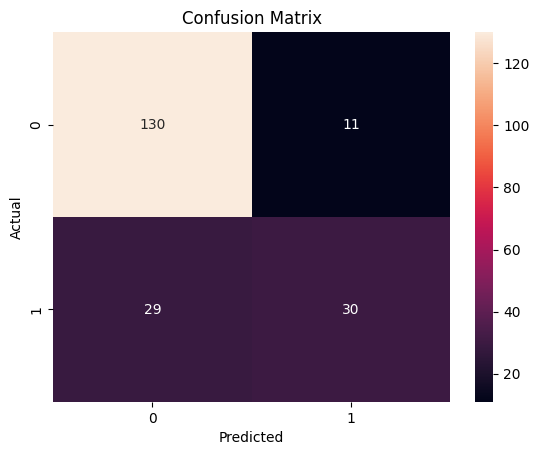

In [24]:
y_pred = model.predict(X_test)
y_pred = y_pred.astype(bool)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
save_plot('Confusion_Matrix.png', plt, SAVE_IMAGES)
plt.show()

**Observations:**
- The model has a higher number of true negatives (upper left) than true positives (lower right), indicating more correct predictions for the negative class.
- There are fewer false negatives (lower left) compared to false positives (upper right), suggesting that the model is more likely to incorrectly predict the positive class than to miss actual positive cases.
- The model's ability to correctly predict the negative class is stronger than its ability to predict the positive class.

#### Feature Importances of the model

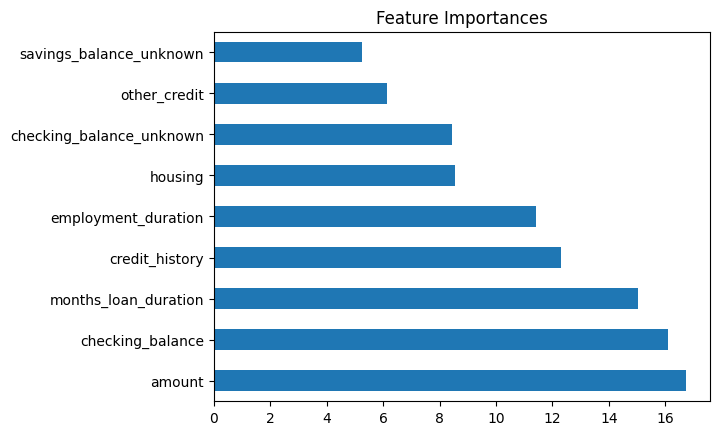

In [25]:
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
save_plot('Feature_Importances.png', plt, SAVE_IMAGES)
plt.show()

**Observations:**
- The amount of the loan is the most influential factor in the model's decisions, followed by checking balance.
- Loan duration and credit history are also significant predictors, but less than loan amount.
- Employment duration and housing have moderate importance.
- Unknown checking and savings balances along with other credit are considered important (but less important) by the model.
- These are the observations of the top 10 most important features, but the model considers all features from training data in its decision-making process.

#### Classification report


Classification report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       141
           1       0.73      0.51      0.60        59

    accuracy                           0.80       200
   macro avg       0.77      0.72      0.73       200
weighted avg       0.79      0.80      0.79       200



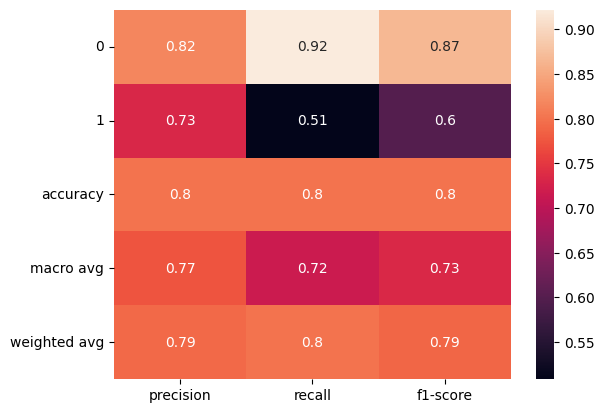

In [26]:
print('\nClassification report:')
print(classification_report(y_test, y_pred))

# Visualize classification report
report = classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
plt.show()

**Observations:**
- Better performance on the negative class with good precision and recall.
- Lower recall for the positive class, indicating missed positive predictions.
- Overall accuracy is solid, but the model favors the negative class.
- Balanced performance across classes could be improved, especially for positive case detection.

#### ROC Curve

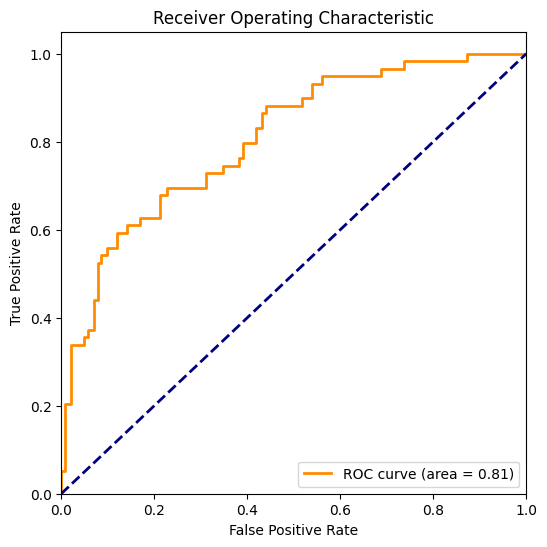

In [27]:
# ROC Curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
save_plot('ROC_Curve.png', plt, SAVE_IMAGES)
plt.show()

**Observations:**
- The model has a good discriminative ability between the positive and negative classes, as evidenced by the curve being closer to the top-left corner and away from the diagonal line, which represents random chance.
- The area under the ROC curve (AUC) suggests that the model's overall performance is quite strong, but there is still some room for improvement to achieve an optimal AUC of 1.0.
- The initial steep slope of the curve suggests that the model quickly gains a high true positive rate without incurring a high false positive rate, which is desirable in a predictive model.

#### Precision-Recall Curve

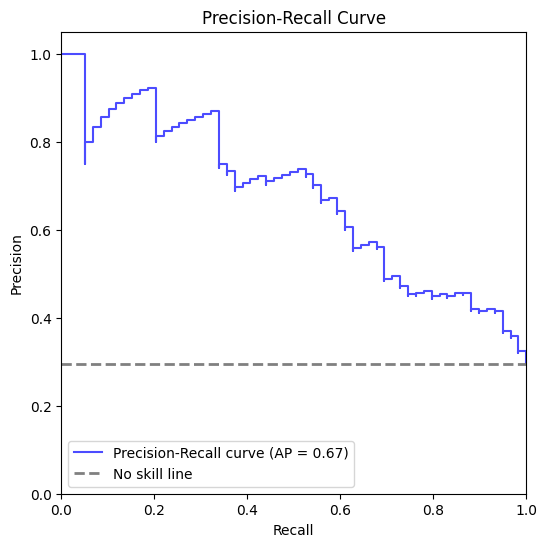

In [28]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post', color='b', alpha=0.7,
         label=f'Precision-Recall curve (AP = {average_precision:.2f})')

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', lw=2, color='grey', label='No skill line')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
save_plot('Precision_Recall_Curve.png', plt, SAVE_IMAGES)
plt.show()

**Observations:**
- The curve starts with high precision, indicating accuracy when the model is selective.
- Precision declines as recall increases, showing the trade-off between recall and accuracy.
- The average precision score is observed to be around 0.65, reflecting moderate overall precision.
- The model's precision is consistently above the no-skill line, demonstrating better than random predictions.
- There are sharp drops in precision at certain recall levels, suggesting areas for potential model improvement.

In [29]:
Markdown(f"### The selected model for this analysis is: **{selected_model_name}**")

### The selected model for this analysis is: **CatBoost**

### Conclusion

This project embarked on a comprehensive exploration of credit default risk prediction using a dataset from a German bank. The journey spanned from exploratory data analysis to the development and evaluation of various machine learning models. The study aimed to answer key questions about the characteristics that distinguish defaulters from non-defaulters and how machine learning models can best predict future defaults. The analysis revealed that factors such as **employment duration, loan amount, and age** significantly influence the likelihood of loan defaults.
<!-- The CatBoost classifier emerged as the most balanced model, demonstrating robust performance in terms of accuracy, F1 score, and ROC AUC score. -->

The study underscores the complexity of credit risk assessment and the potential of machine learning in this domain. <!-- While the CatBoost model excelled in terms of accuracy and overfitting, other models like Gradient Boosting and Random Forest also showed commendable performance, highlighting the utility of a diverse set of models in predicting loan defaults. --> The project also identified limitations such as the reliance on historical data and suggested future research directions, including the use of more dynamic models and alternative data sources. The insights gained from this project can assist financial institutions in refining their risk assessment algorithms and loan approval criteria, potentially reducing the incidence of loan defaults.